In [24]:
from utils.data_utils import *
from model.fl_model import VerticalFLModel
from model.simple_fl_model import PCAVerticalFLModel
from model.single_party_model import SingleParty
from model.split_nn_model import SplitNNModel
from utils.split_train_test import split_train_test

from torch.utils.tensorboard import SummaryWriter

import os.path
import wget
import bz2
import shutil
import numpy as np

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime


In [4]:
!pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 61 kB 1.9 MB/s eta 0:00:01


In [6]:
if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.isfile("data/phishing"):
    print("Downloading phishing data")
    wget.download("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/phishing",
                  "data/phishing")

if not os.path.isfile("data/phishing.train") or not os.path.isfile("data/phishing.test"):
    split_train_test("phishing", file_type='libsvm', test_rate=0.1)

In [26]:
num_parties = 2
x_scaler_wrapper = []
y_scaler_wrapper = []
x_normalizer_wrapper = []

cross_valid_data = load_data_cross_validation("phishing.train", num_parties=num_parties,
                                              file_type='libsvm', n_fold=5, use_cache=False,
                                              x_scaler_wrapper=x_scaler_wrapper, y_scaler_wrapper=y_scaler_wrapper,
                                              x_normalizer_wrapper=x_normalizer_wrapper)

Loading data from file
Percentage of positive labels: 55.59352698763694
Scaling labels
5 fold spliltting
Fold 0 finished
Fold 1 finished
Fold 2 finished
Fold 3 finished
Fold 4 finished


In [36]:
cross_valid_data[3][0][0].shape

(7959, 34)

In [25]:
xs_train, y_train, xs_test, y_test, x_train, x_test = load_data_train_test("phishing", num_parties=1,
                                                                           test_size=0.2, file_type='libsvm')

Data splitting


TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

In [21]:
cross_valid_data[0][0][1].shape

IndexError: list index out of range

In [15]:
# SecureBoost with DP (use XGBoost instead since SecureBoost is lossless)
num_parties = 2
x_scaler_wrapper = []
y_scaler_wrapper = []
x_normalizer_wrapper = []
cross_valid_data = load_data_cross_validation("phishing.train", num_parties=num_parties,
                                              file_type='libsvm', n_fold=5, use_cache=False,
                                              x_scaler_wrapper=x_scaler_wrapper, y_scaler_wrapper=y_scaler_wrapper,
                                              x_normalizer_wrapper=x_normalizer_wrapper)
xs_test, y_test = load_data_cross_validation("phishing.test", num_parties=num_parties,
                                             file_type='libsvm', n_fold=1, use_cache=False,
                                             x_scaler_wrapper=x_scaler_wrapper, y_scaler_wrapper=y_scaler_wrapper,
                                             x_normalizer_wrapper=x_normalizer_wrapper)[0]

Loading data from file
Percentage of positive labels: 55.59352698763694
Scaling labels
5 fold spliltting
Fold 0 finished
Fold 1 finished
Fold 2 finished
Fold 3 finished
Fold 4 finished
Loading data from file
Percentage of positive labels: 56.6003616636528
Scaling labels
1 fold spliltting


array([1., 0., 0., ..., 0., 1., 0.])

In [1]:
import warnings

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

from scipy.sparse import csr_matrix
from imblearn.under_sampling import RandomUnderSampler

import numpy as np
import torch
from torch.utils.data import TensorDataset, Dataset
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST, KMNIST
from torchvision.transforms import transforms

from typing import List
import os.path
import pickle
import patoolib
import wget
import zipfile

import pandas as pd

from utils.utils import get_closest_factor

from utils.exceptions import *

In [2]:
file_name = "phishing"
num_parties=1
file_type='libsvm'
n_fold=5
root="data/"
x_normalizer_wrapper = None
x_scaler_wrapper=None
y_scaler_wrapper=None
x_normalizer_wrapper=None
feature_order=None
shift_alpha=None
feature_ratio_beta=None
good_feature_ratio_alpha = None
remove_noise = None
use_cache = None

def vertical_split(x, num_parties):
    if isinstance(x, csr_matrix):
        x = x.todense()

    num_features = x.shape[1]
    xs = []
    for i in range(num_parties):
        if i == num_parties - 1:
            x_train_party_i = x[:, i * num_features // num_parties:]
        else:
            x_train_party_i = x[:, i * num_features // num_parties: (i + 1) * num_features // num_parties]
        xs.append(x_train_party_i)
    return xs

print("Loading data from file")
if file_type == 'libsvm':
    x, y = load_svmlight_file(root + file_name)
    x = x.todense()
    x = np.asarray(x)

    print("Percentage of positive labels: " + str(np.sum(y) / len(y) * 100))

    if x_normalizer_wrapper is not None and len(x_normalizer_wrapper) == 1:
        normalizer = x_normalizer_wrapper[0]
    else:
        normalizer = Normalizer().fit(x)
        if x_normalizer_wrapper is not None:
            x_normalizer_wrapper.append(normalizer)
    if x_scaler_wrapper is not None and len(x_scaler_wrapper) == 1:
        x_scaler = x_scaler_wrapper[0]
    else:
        x_scaler = MinMaxScaler(feature_range=(0, 1))
        x_scaler.fit(x)
        if x_scaler_wrapper is not None:
            x_scaler_wrapper.append(x_scaler)
    x = normalizer.transform(x_scaler.transform(x))
elif file_type == 'csv':
    try:
        dataset = np.loadtxt(root + file_name, delimiter=',', skiprows=csv_skiprows)
    except ValueError:
        dataset = np.genfromtxt(root + file_name, delimiter=',', skip_header=csv_skiprows, filling_values=0)
    x = dataset[:, :-1]
    y = dataset[:, -1].reshape(-1)
    if x_normalizer_wrapper is not None and len(x_normalizer_wrapper) == 1:
        normalizer = x_normalizer_wrapper[0]
    else:
        normalizer = Normalizer().fit(x)
        if x_normalizer_wrapper is not None:
            x_normalizer_wrapper.append(normalizer)
    if x_scaler_wrapper is not None and len(x_scaler_wrapper) == 1:
        x_scaler = x_scaler_wrapper[0]
    else:
        x_scaler = MinMaxScaler(feature_range=(0, 1))
        x_scaler.fit(x)
        if x_scaler_wrapper is not None:
            x_scaler_wrapper.append(x_scaler)
    x = normalizer.transform(x_scaler.transform(x))

elif file_type == 'torch':
    if file_name == 'cifar10':
        # trainset will be normalized later in vertical_fl.py after data argumentation
        dataset = CIFAR10(root=root, train=True, transform=None, download=True)
        x, y = dataset.data, np.array(dataset.targets)
    elif file_name == 'mnist':
        dataset = MNIST(root=root, train=True, transform=None, download=True)
        x, y = dataset.data.detach().numpy()[:, :, :, None], np.array(dataset.targets)
    else:
        raise UnsupportedFormatError
else:
    raise UnsupportedFormatError

print("Scaling labels")
# scale labels if regression or binary classification
if file_type in ['libsvm', 'csv']:
    if y_scaler_wrapper is not None and len(y_scaler_wrapper) == 1:
        scalar = y_scaler_wrapper[0]
    else:
        scalar = MinMaxScaler(feature_range=(0, 1))
        scalar.fit(y.reshape(-1, 1))
        if y_scaler_wrapper is not None:
            y_scaler_wrapper.append(scalar)
    y = scalar.transform(y.reshape(-1, 1)).reshape(-1)
elif file_type in ['torch']:
    pass
else:
    raise UnsupportedFormatError

if feature_order is not None:
    assert feature_order.size == x.shape[1], "Feature orders mismatch the number of features"
    x = x[:, feature_order]

if shift_alpha is not None:
    shift = -int(x.shape[1] * shift_alpha)
    x = np.roll(x, shift, axis=1)

print("{} fold spliltting".format(n_fold))
results = []
if n_fold > 1:
    k_fold = KFold(n_splits=n_fold, shuffle=True, random_state=10)
    for i, (train_idx, test_idx) in enumerate(k_fold.split(x, y)):
        x_train = x[train_idx]
        y_train = y[train_idx]
        x_test = x[test_idx]
        y_test = y[test_idx]

        # split data into parties
        if file_type in ['libsvm', 'csv']:
            if feature_ratio_beta is not None:
                assert num_parties == 2
                if remove_noise:
                    xs_train = bias_vertical_split(x_train, feature_ratio_beta)
                    xs_train = rm_noise_list([*xs_train])
                    y_train = rm_noise(y_train)
                    xs_test = bias_vertical_split(x_test, feature_ratio_beta)
                elif overlap_ratio > 0:
                    xs_train = bias_vertical_split_overlap(x_train, feature_ratio_beta, overlap_ratio)
                    xs_test = bias_vertical_split_overlap(x_test, feature_ratio_beta, overlap_ratio)
                else:
                    xs_train = bias_vertical_split(x_train, feature_ratio_beta, add_noise)
                    xs_test = bias_vertical_split(x_test, feature_ratio_beta)
            elif good_feature_ratio_alpha is not None and num_good_features is not None:
                assert num_parties == 2
                xs_train, xs_test = bias_vertical_split_ratio(
                    x_train, x_test, num_good_features, good_feature_ratio_alpha)
            else:
                if remove_noise:
                    xs_train = vertical_split(x_train, num_parties)
                    xs_test = vertical_split(x_test, num_parties)
                    xs_train = rm_noise_list([*xs_train])
                    y_train = rm_noise(y_train)
                else:
                    xs_train = vertical_split(x_train, num_parties)
                    xs_test = vertical_split(x_test, num_parties)
        elif file_type in ['torch']:
            xs_train = vertical_split_image(x_train, num_parties)
            xs_test = vertical_split_image(x_test, num_parties)
        else:
            raise UnsupportedFormatError

        results.append([xs_train, y_train, xs_test, y_test])
        print("Fold {} finished".format(i))
else:       # fold = 1
    # split data into parties
    if file_type in ['libsvm', 'csv']:
        if feature_ratio_beta is not None:
            assert num_parties == 2
            xs = bias_vertical_split(x, feature_ratio_beta)
        elif good_feature_ratio_alpha is not None and num_good_features is not None:
            assert False, "Unsupported"
            # assert num_parties == 2
            # xs_train, xs_test = bias_vertical_split_ratio(
            #     x, x, num_good_features, good_feature_ratio_alpha)
        else:
            xs = vertical_split(x, num_parties)
    elif file_type in ['torch']:
        xs = vertical_split_image(x, num_parties)
    else:
        raise UnsupportedFormatError
    results.append([xs, y])

if use_cache and cache_path is not None:
    with open(cache_path, 'wb') as f:
        pickle.dump(results, f)
    print("Saved results to cache: " + str(cache_path))



Loading data from file
Percentage of positive labels: 55.69425599276345
Scaling labels
5 fold spliltting
Fold 0 finished
Fold 1 finished
Fold 2 finished
Fold 3 finished
Fold 4 finished


In [3]:
x_train.shape

(8844, 68)

In [4]:
x_test.shape

(2211, 68)

In [7]:
x_train_deduplicated = np.unique(x_train, axis=0)
x_train_deduplicated.shape

(5077, 68)

In [8]:
x_test_deduplicated = np.unique(x_test, axis=0)
x_test_deduplicated.shape

(1847, 68)

In [10]:
x.shape

(11055, 68)

In [18]:
_, unique_indices = np.unique(x, axis=0, return_index=True)
x = x[unique_indices]
y = y[unique_indices]

In [25]:
x.shape

(5785, 68)

In [26]:
y.shape

(5785,)

In [30]:
percent_to_take = 0.1
num_rows_to_take = int(x.shape[0] * percent_to_take)

# Sử dụng hàm numpy.random.choice để lấy ngẫu nhiên các dòng
selected_rows_indices = np.random.choice(x.shape[0], num_rows_to_take, replace=False)
selected_rows = x[selected_rows_indices, :]
selected_y = y[selected_rows_indices]

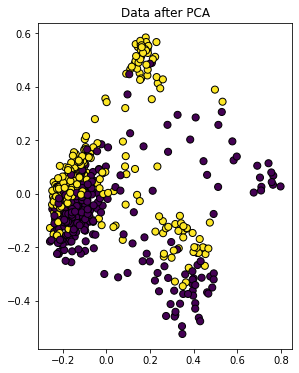

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(selected_rows)

# Visualize the data
plt.figure(figsize=(10, 6))


# Plot the PCA-transformed data colored by the labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=selected_y, cmap='viridis', edgecolor='k', s=50)
plt.title('Data after PCA')

plt.show()

Text(0.5, 1.0, 'Data after t-SNE')

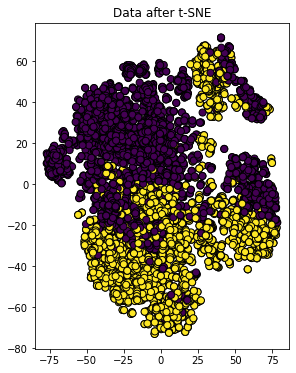

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x)

# Visualize the data
plt.figure(figsize=(10, 6))


# Plot the t-SNE-transformed data colored by the labels
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title('Data after t-SNE')


Text(0.5, 1.0, 'Data after t-SNE')

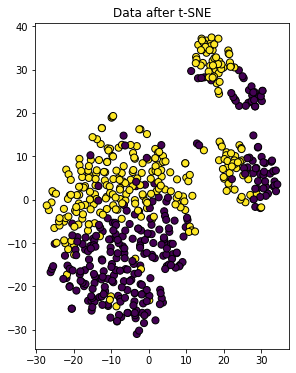

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(selected_rows)

# Visualize the data
plt.figure(figsize=(10, 6))


# Plot the t-SNE-transformed data colored by the labels
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=selected_y, cmap='viridis', edgecolor='k', s=50)
plt.title('Data after t-SNE')


In [17]:
x_unique[-2]

array([0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.18257419, 0.        , 0.        , 0.18257419, 0.        ,
       0.18257419, 0.18257419, 0.18257419, 0.        , 0.18257419,
       0.18257419, 0.        , 0.        , 0.18257419, 0.        ,
       0.18257419, 0.        , 0.18257419, 0.        , 0.        ,
       0.18257419, 0.        , 0.18257419, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18257419, 0.18257419,
       0.        , 0.18257419, 0.18257419, 0.        , 0.18257419,
       0.        , 0.18257419, 0.        , 0.18257419, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18257419,
       0.        , 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.18257419, 0.        , 0.        ])

In [19]:
check_equal = [np.array_equal(row_a, row_b) for row_a in x_train for row_b in x_test]

In [20]:
has_common_row = any(np.array_equal(row_a, row_b) for row_a in x_train for row_b in x_test)

In [21]:
has_common_row

True

In [22]:
x

array([[0.18257419, 0.18257419, 0.18257419, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18257419, 0.18257419, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.18257419, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.18257419, ..., 0.        , 0.        ,
        0.        ],
       [0.18257419, 0.        , 0.18257419, ..., 0.18257419, 0.        ,
        0.        ],
       [0.18257419, 0.        , 0.18257419, ..., 0.        , 0.18257419,
        0.        ]])

In [29]:
indices, counts

(array([   15, 10518,  7593, ...,  6492,  9511,     0]),
 array([4, 1, 1, ..., 2, 2, 4]))

In [22]:
def get_duplicate_rows(arr):
    # Chuyển mảng thành mảng 1D của tuples (dòng) để kiểm tra sự trùng lặp
    unique_rows, inverse_indices, counts = np.unique(arr, axis=0, return_inverse=True, return_counts=True)
    
    # Lấy chỉ mục của các dòng bị trùng lặp
    duplicate_indices = np.where(counts[inverse_indices] > 1)[0]
    
    # Lấy ra các dòng bị trùng lặp từ mảng gốc
    duplicate_rows = arr[duplicate_indices]
    
    return duplicate_rows

In [24]:
unique_rows, inverse_indices, counts = np.unique(x, axis=0, return_inverse=True, return_counts=True)


In [26]:
x.shape

(11055, 68)

In [25]:
unique_rows.shape

(5785, 68)

In [34]:
x[0]

array([0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [35]:
x[1]

array([0.        , 0.18257419, 0.18257419, 0.18257419, 0.        ,
       0.18257419, 0.        , 0.        , 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.        , 0.        ,
       0.18257419, 0.        , 0.        , 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.        , 0.18257419, 0.18257419, 0.18257419, 0.        ,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.18257419, 0.18257419, 0.18257419, 0.18257419, 0.18257419,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [47]:
matching_rows = np.all(x == x[10], axis=1)

# Lấy chỉ mục của các dòng trùng với dòng A
indices_matching_A = np.where(matching_rows)[0]

# Lấy ra các dòng trùng với dòng A từ mảng gốc
rows_matching_A = x[indices_matching_A]

In [48]:
rows_matching_A.shape

(4, 68)

In [46]:
x, y = load_svmlight_file(root + file_name)
x = x.todense()
x = np.asarray(x)

In [1]:
from utils.data_utils import load_data_cross_validation, load_movielens, load_creditcardfraud
from model.fl_model import VerticalFLModel
from model.single_party_model import SingleParty
from model.split_nn_model import SplitNNModel

In [7]:
import numpy as np

In [31]:
xs_train_val, y_train_val, xs_test, y_test = load_creditcardfraud("data/creditcard/creditcard.csv", use_cache = False,
                                                        test_rate = 0.1)

Loading creditcardfraud from file


In [32]:
xs_train_val[1].shape

(256326, 21)

In [33]:
xs_train_val = np.concatenate(xs_train_val, axis = 1)

In [34]:
xs_test = np.concatenate(xs_test, axis = 1)

In [12]:
check_equal = [np.array_equal(row_a, row_b) for row_a in xs_train_val for row_b in xs_test]

KeyboardInterrupt: 

In [35]:
arr = np.concatenate([xs_train_val, xs_test], axis = 0)
unique_rows, inverse_indices, counts = np.unique(arr, axis=0, return_inverse=True, return_counts=True)


In [36]:
unique_rows.shape

(275663, 29)

In [37]:
arr.shape

(284807, 29)

In [38]:
unique_rows.shape[0]/arr.shape[0]

0.9678940475479887

In [35]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 
  
# metadata 
print(default_of_credit_card_clients.metadata) 
  
# variable information 
print(default_of_credit_card_clients.variables) 


{'uci_id': 350, 'name': 'Default of credit card clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'The comparisons of data mining techniques for the predictive accuracy of probability of default of cre

In [41]:
X.to_numpy()

array([[ 20000,      2,      2, ...,      0,      0,      0],
       [120000,      2,      2, ...,   1000,      0,   2000],
       [ 90000,      2,      2, ...,   1000,   1000,   5000],
       ...,
       [ 30000,      1,      2, ...,   4200,   2000,   3100],
       [ 80000,      1,      3, ...,   1926,  52964,   1804],
       [ 50000,      1,      2, ...,   1000,   1000,   1000]])

In [38]:
y

(30000, 1)

Text(0.5, 1.0, 'Data after t-SNE')

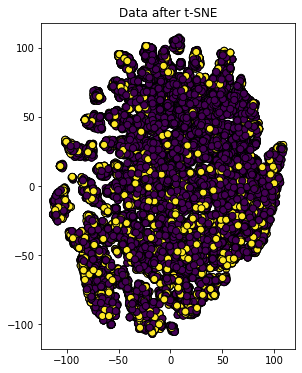

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.to_numpy())

# Visualize the data
plt.figure(figsize=(10, 6))


# Plot the t-SNE-transformed data colored by the labels
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.to_numpy(), cmap='viridis', edgecolor='k', s=50)
plt.title('Data after t-SNE')
